# Imports

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Read Data

In [2]:
df = pd.read_csv('datasets/household_power_consumption.csv', usecols=['Date','Time','Global_active_power'])
df.info(), df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260640 entries, 0 to 260639
Data columns (total 3 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Date                 259394 non-null  object
 1   Time                 260395 non-null  object
 2   Global_active_power  260616 non-null  object
dtypes: object(3)
memory usage: 6.0+ MB


(None,
 Date                   1246
 Time                    245
 Global_active_power      24
 dtype: int64)

# Data Preparation

## Data Wrangling

In [3]:
df = df.iloc[::10,:]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26064 entries, 0 to 260630
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Date                 25939 non-null  object
 1   Time                 26038 non-null  object
 2   Global_active_power  26062 non-null  object
dtypes: object(3)
memory usage: 611.0+ KB


In [4]:
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce', downcast='float')
df.dtypes

Date                    object
Time                    object
Global_active_power    float32
dtype: object

In [5]:
df.dropna(axis=0, inplace=True) # axis = 0 for rows, axis = 1 for columns
df.isnull().sum()

Date                   0
Time                   0
Global_active_power    0
dtype: int64

## New Data Column

In [6]:
df['Datetime'] = df.apply(lambda x: x['Date'] + ' ' + x['Time'], axis=1)
df['Datetime']

0             1/1/07 0:00:00
10            1/1/07 0:10:00
20            1/1/07 0:20:00
30            1/1/07 0:30:00
40            1/1/07 0:40:00
                 ...        
260590    30/6/2007 23:10:00
260600    30/6/2007 23:20:00
260610    30/6/2007 23:30:00
260620    30/6/2007 23:40:00
260630    30/6/2007 23:50:00
Name: Datetime, Length: 25535, dtype: object

## Visualize Data

<AxesSubplot:xlabel='Date', ylabel='Power Consumption (Kilowatt)'>

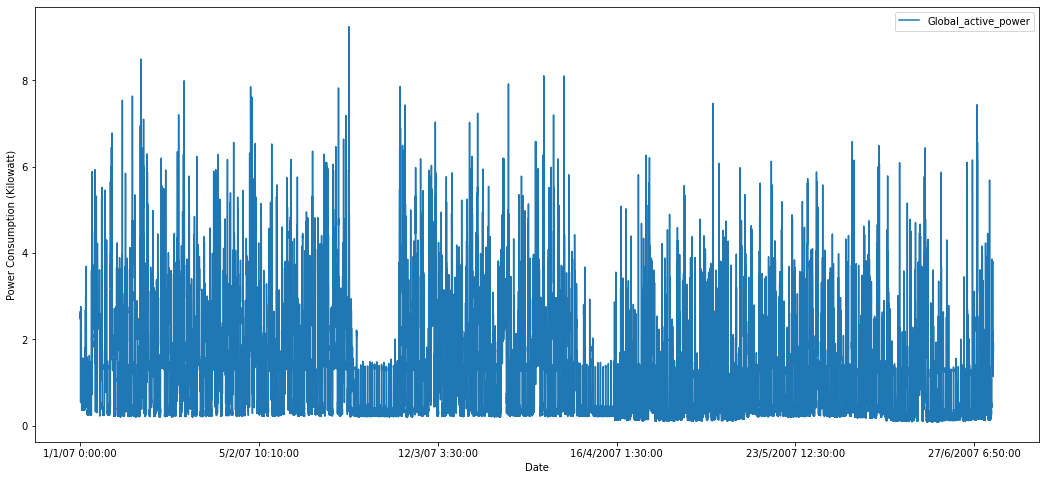

In [7]:
df.plot('Datetime', 'Global_active_power', figsize=(18,8), ylabel='Power Consumption (Kilowatt)', xlabel='Date')

## Scale Data

In [8]:
scaler = MinMaxScaler(feature_range=(-1, 1))
# Reshape because of single feature array
df['Global_active_power'] = scaler.fit_transform(df['Global_active_power'].values.reshape(-1, 1))
df['Global_active_power']

0        -0.455022
10       -0.474236
20       -0.462882
30       -0.440175
40       -0.450218
            ...   
260590   -0.720087
260600   -0.768559
260610   -0.724454
260620   -0.627948
260630   -0.598690
Name: Global_active_power, Length: 25535, dtype: float32

<AxesSubplot:xlabel='Date', ylabel='Power Consumption (Kilowatt)'>

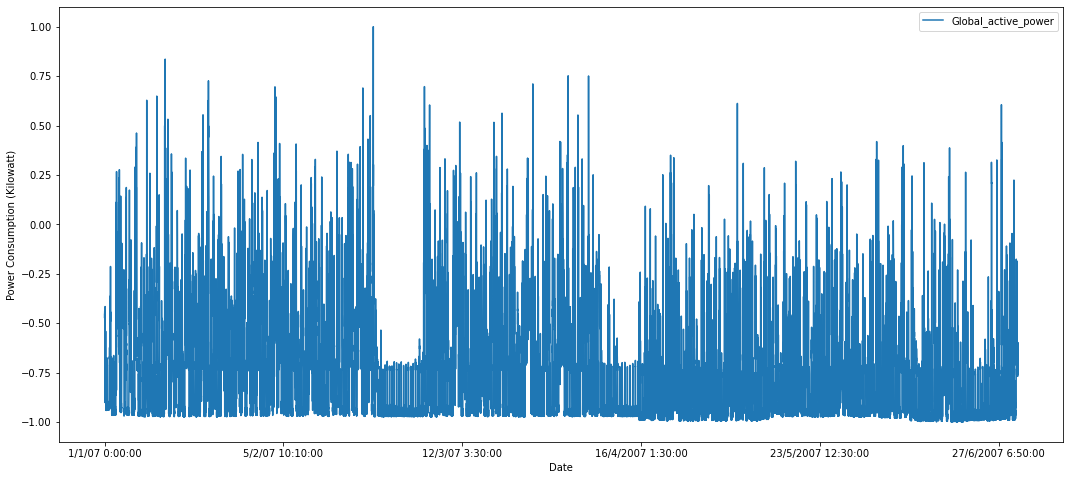

In [9]:
df.plot('Datetime', 'Global_active_power', figsize=(18,8), ylabel='Power Consumption (Kilowatt)', xlabel='Date')

# Data Split

In [10]:
def load_data(stock, lookback):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # Create all possible sequences of length lookback
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])
        
    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    valid_set_size = int(np.round(0.2*(data.shape[0] - test_set_size)))
    train_set_size = data.shape[0] - test_set_size - valid_set_size
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

In [11]:
lookback = 6 * 24 # define sequence length

x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df[['Global_active_power']], lookback)

print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ',y_valid.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (16250, 143, 1)
y_train.shape =  (16250, 1)
x_valid.shape =  (4063, 143, 1)
y_valid.shape =  (4063, 1)
x_test.shape =  (5078, 143, 1)
y_test.shape =  (5078, 1)


## Convert datasets to tensors

In [12]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
x_valid = torch.from_numpy(x_valid).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)
y_valid = torch.from_numpy(y_valid).type(torch.Tensor)

# Structure Models

## Parameters

In [13]:
input_dim = 1
num_layers = 2
hidden_dim = 16
output_dim = 1
dropout_prob = 0.2

## Vanilla RNN

In [14]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, num_layers, hidden_dim, output_dim, dropout_prob):
        super(RNNModel, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        self.num_layers = num_layers
        
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_prob)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        
        out, _ = self.rnn(x, (h0.detach()))
        
        # Reshape the output of the last time step
        out = out[:, -1, :]
        
        out = self.fc(out)
        
        return out

## LSTM

In [15]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, num_layers, hidden_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_prob)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        
        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        
        out = out[:, -1, :]
        
        out = self.fc(out)
        
        return out

## GRU

In [16]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout_prob):
        super(GRUModel, self).__init__()

        self.num_layers = num_layers
        
        self.hidden_dim = hidden_dim

        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_prob)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        out, _ = self.gru(x, h0.detach())

        out = out[:, -1, :]

        out = self.fc(out)

        return out

In [17]:
torch.manual_seed(420)
rnn_model = RNNModel(input_dim=input_dim, num_layers=num_layers, hidden_dim=hidden_dim, output_dim=output_dim, dropout_prob=dropout_prob)
torch.manual_seed(69)
lstm_model = LSTMModel(input_dim=input_dim, num_layers=num_layers, hidden_dim=hidden_dim, output_dim=output_dim, dropout_prob=dropout_prob)
torch.manual_seed(42)
gru_model = GRUModel(input_dim=input_dim, num_layers=num_layers, hidden_dim=hidden_dim, output_dim=output_dim, dropout_prob=dropout_prob)

loss_fn = torch.nn.MSELoss()

rnn_optimiser = torch.optim.Adam(rnn_model.parameters(), lr=0.01)
lstm_optimiser = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
gru_optimiser = torch.optim.Adam(gru_model.parameters(), lr=0.01)

# Validation loop

In [18]:
def validate(model, optimiser):
    num_epochs = 10
    hist = np.zeros(num_epochs)

    for t in range(num_epochs):
        # Forward pass
        y_valid_pred = model(x_valid)
    
        loss = loss_fn(y_valid_pred, y_valid)
        print("Epoch ", t, "MSE: ", loss.item())
        
        hist[t] = loss.item()
    
        # Zero out gradient, else they well accumulate between epochs
        optimiser.zero_grad()
    
        # Backward propagation
        loss.backward()
    
        # Update parameters
        optimiser.step()
        
    return hist

In [19]:
print("Vanilla RNN:")
rnn_hist = validate(rnn_model, rnn_optimiser)
print("\nLSTM:")
lstm_hist = validate(lstm_model, lstm_optimiser)
print("\nGRU:")
gru_hist = validate(gru_model, gru_optimiser)

Vanilla RNN:
Epoch  0 MSE:  1.3048313856124878
Epoch  1 MSE:  0.6658956408500671
Epoch  2 MSE:  0.296039879322052
Epoch  3 MSE:  0.09321220219135284
Epoch  4 MSE:  0.04441679269075394
Epoch  5 MSE:  0.10129234194755554
Epoch  6 MSE:  0.13757219910621643
Epoch  7 MSE:  0.12650814652442932
Epoch  8 MSE:  0.08914051949977875
Epoch  9 MSE:  0.058042459189891815

LSTM:
Epoch  0 MSE:  1.268784523010254
Epoch  1 MSE:  1.0880157947540283
Epoch  2 MSE:  0.9371275901794434
Epoch  3 MSE:  0.7957040667533875
Epoch  4 MSE:  0.6519261002540588
Epoch  5 MSE:  0.4999333322048187
Epoch  6 MSE:  0.34015926718711853
Epoch  7 MSE:  0.18883374333381653
Epoch  8 MSE:  0.08111092448234558
Epoch  9 MSE:  0.046417128294706345

GRU:
Epoch  0 MSE:  0.40294408798217773
Epoch  1 MSE:  0.26146847009658813
Epoch  2 MSE:  0.14787082374095917
Epoch  3 MSE:  0.06652292609214783
Epoch  4 MSE:  0.0444442443549633
Epoch  5 MSE:  0.08770190179347992
Epoch  6 MSE:  0.10497825592756271
Epoch  7 MSE:  0.08329744637012482
Epoc

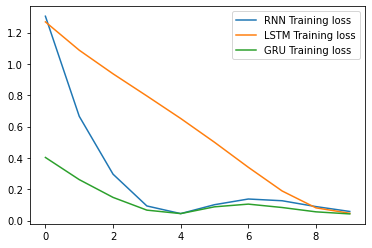

In [20]:
plt.plot(rnn_hist, label='RNN Training loss')
plt.plot(lstm_hist, label='LSTM Training loss')
plt.plot(gru_hist, label='GRU Training loss')
plt.legend()
plt.show()

## Clear up memory

In [21]:
del rnn_model, lstm_model, gru_model, rnn_optimiser, lstm_optimiser, gru_optimiser

## Tuning learning rate

Based on LSTM since it scores the lowest mean squared error

In [22]:
def validate_learning_rate(learning_range):
    num_epochs = 10
    
    hists = []
    
    for l in learning_range:
        hist = np.zeros(num_epochs)
        
        torch.manual_seed(42)        
        model = LSTMModel(input_dim=input_dim, num_layers=num_layers, hidden_dim=hidden_dim, output_dim=output_dim, dropout_prob=dropout_prob)
        
        optimiser = torch.optim.Adam(model.parameters(), lr=l)

        for t in range(num_epochs):
            # Forward pass
            y_valid_pred = model(x_valid)
    
            loss = loss_fn(y_valid_pred, y_valid)
        
            hist[t] = loss.item()
    
            # Zero out gradient, else they well accumulate between epochs
            optimiser.zero_grad()
    
            # Backward propagation
            loss.backward()
    
            # Update parameters
            optimiser.step()
            
        print(f"Mean loss for learning rate {l}: {hist.mean()}")
        
        hists.append(hist)
    
    return hists

In [23]:
learning_rates = np.arange(0.005, 0.011, 0.001)
learning_rates

array([0.005, 0.006, 0.007, 0.008, 0.009, 0.01 ])

In [24]:
histories = validate_learning_rate(learning_rates)

Mean loss for learning rate 0.005: 0.3694066062569618
Mean loss for learning rate 0.006: 0.32464933954179287
Mean loss for learning rate 0.007: 0.2992970120161772
Mean loss for learning rate 0.008: 0.2822268158197403
Mean loss for learning rate 0.009000000000000001: 0.2684383910149336
Mean loss for learning rate 0.01: 0.253768465667963


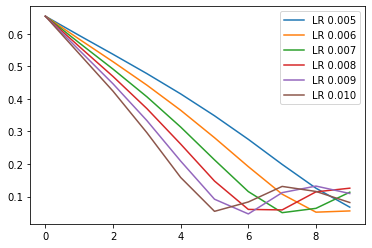

In [25]:
for i in range(learning_rates.shape[0]):
    plt.plot(histories[i], label=f"LR {learning_rates[i]:.3f}")
plt.legend()
plt.show()

In [26]:
last_mse = [x[-1] for x in histories]
last_mse

[0.06753012537956238,
 0.05598662793636322,
 0.11348061263561249,
 0.12581785023212433,
 0.10946106910705566,
 0.08183691650629044]

In [27]:
import seaborn as sns 

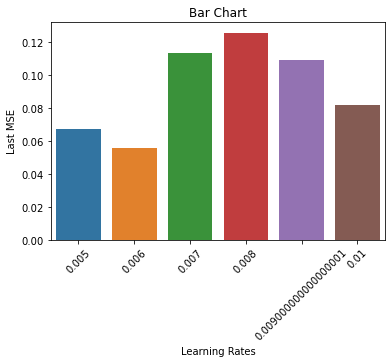

In [28]:
sns.barplot(x=learning_rates, y=last_mse)
plt.xlabel('Learning Rates')
plt.ylabel('Last MSE')
plt.title('Bar Chart')
plt.xticks(rotation=45)
plt.show()

# Training loop

In [29]:
torch.manual_seed(42)        
model = LSTMModel(input_dim=input_dim, num_layers=num_layers, hidden_dim=hidden_dim, output_dim=output_dim, dropout_prob=dropout_prob)
        
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rates[np.argmin(last_mse)])

num_epochs = 10
hist = np.zeros(num_epochs)

for t in range(num_epochs):
    # Initialize hidden state here if you want your LSTM to be stateless
    
    # Forward pass
    y_train_pred = model(x_train)
    
    loss = loss_fn(y_train_pred, y_train)

    print("Epoch ", t, "MSE: ", loss.item())
        
    hist[t] = loss.item()
    
    # Zero out gradient, else they well accumulate between epochs
    optimiser.zero_grad()
    
    # Backward propagation
    loss.backward()
    
    # Update parameters
    optimiser.step()

Epoch  0 MSE:  0.5691113471984863
Epoch  1 MSE:  0.5057453513145447
Epoch  2 MSE:  0.44389787316322327
Epoch  3 MSE:  0.3804915249347687
Epoch  4 MSE:  0.31297948956489563
Epoch  5 MSE:  0.24064792692661285
Epoch  6 MSE:  0.16643574833869934
Epoch  7 MSE:  0.10185512155294418
Epoch  8 MSE:  0.07014377415180206
Epoch  9 MSE:  0.0952889546751976


## Visualize testing results

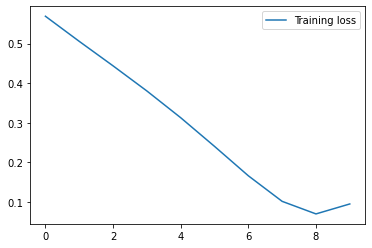

In [30]:
plt.plot(hist, label='Training loss')
plt.legend()
plt.show()

# Predictions

In [31]:
model.eval()
y_test_pred = model(x_test)

## Compare train vs test

In [32]:
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# Calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.41 RMSE
Test Score: 1.20 RMSE


## Visualize results

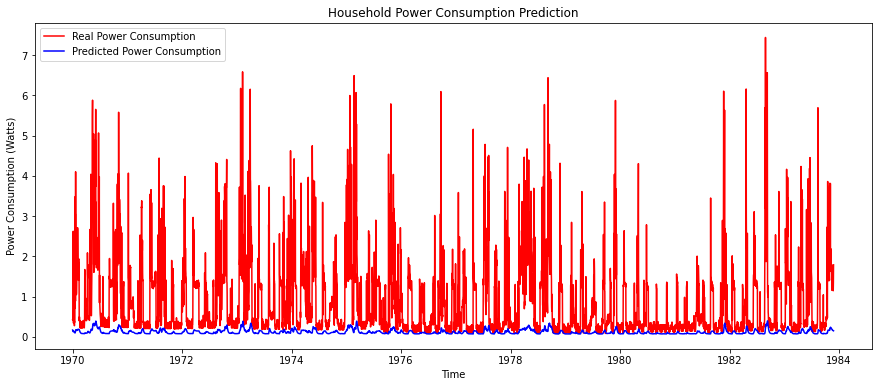

In [33]:
# dates = pd.to_datetime(df['Datetime']) # Convert dates to numpy array
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()
axes.plot(y_test, color = 'red', label = 'Real Power Consumption')
axes.plot(y_test_pred, color = 'blue', label = 'Predicted Power Consumption')
plt.title('Household Power Consumption Prediction')
plt.xlabel('Time')
plt.ylabel('Power Consumption (Watts)')
plt.legend()
plt.show()

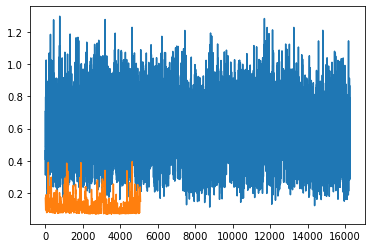

In [36]:
plt.plot(y_train_pred)
plt.plot(y_test_pred)

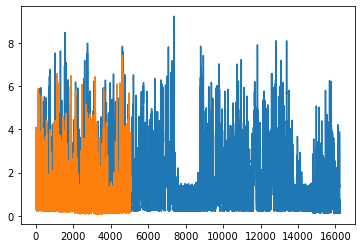

In [37]:
plt.plot(y_train)
plt.plot(y_test)